In [1]:
from si import *

Not a jupyter notebook. Not enabling notebook functions.
Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


# Slow term search using KS statistic on energy spectrum

### Goal: look at the energy spectrum very late in the fill, compare with rolling omega_a period, see if we can see anything strange

---


In [2]:
f = r.TFile("./data/run2c_pileup_corrected_non.root")
f.cd("clustersAndCoincidences")
f.ls()

TFile**		./data/run2c_pileup_corrected_non.root	
 TFile*		./data/run2c_pileup_corrected_non.root	
  TDirectoryFile*		clustersAndCoincidences	clustersAndCoincidences
   KEY: TH3D	uncorrected;1	uncorrected
   KEY: TH3D	corrected;1	corrected
   KEY: TH2I	triples;1	triples
   KEY: TH2I	quadruples;1	quadruples
   KEY: TH1I	ctag;1	ctag
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences


In [3]:
h = f.Get("clustersAndCoincidences/corrected").Clone()

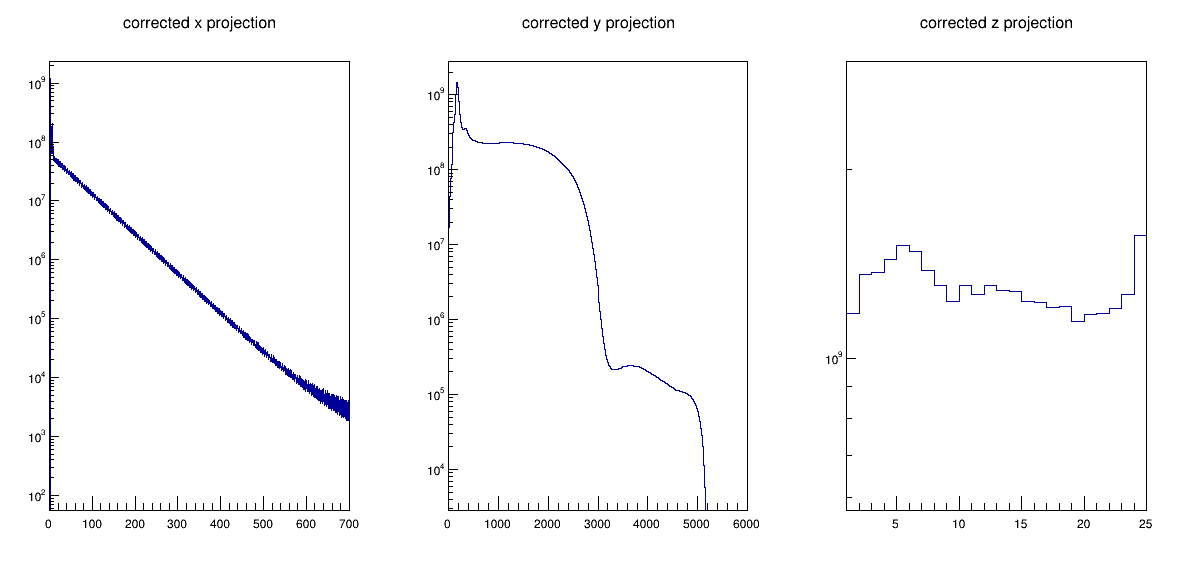

In [4]:
c = r.TCanvas("c","c",1200,600)
c.Divide(3)
for i,xi in enumerate(['x','y','z']):
    c.cd(i+1)
    h.Project3D(xi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [5]:
omega_a_period = 4.37 # microseconds

In [6]:
width = h.GetXaxis().GetBinWidth(10)
print(width)
print(omega_a_period/width)
print(width*29)

0.14919011082693948
29.291485714285713
4.3265132139812446


### We only care about things which make it into our omega_a fits, so we can ignore everything below a certain energy

In [7]:
eLow = 1000
eHigh = 3100

tlow = 25
thigh = 400

In [8]:
h.GetYaxis().SetRangeUser(eLow,eHigh)

### Lets get our reference spectrum

In [9]:
nperiods = 50
thigh1 = 400
thigh2 = thigh1 + nperiods * omega_a_period
print(thigh1, thigh2)
# thigh2 = 700 #change to N exact g-2 periods

h.GetXaxis().SetRangeUser(thigh1, thigh2)

ref_spectrum = h.Project3D("y").Clone("ref_spectrum")
ref_spectrum.Scale(1/ref_spectrum.Integral())

400 618.5


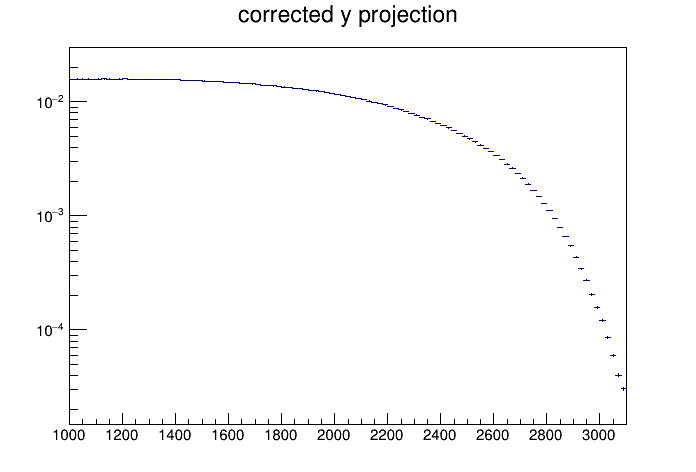

In [10]:
c = r.TCanvas()
ref_spectrum.Draw()
c.SetLogy()
c.Draw()

In [11]:
samp = []
for i in range(100000):
    samp.append(ref_spectrum.GetRandom())

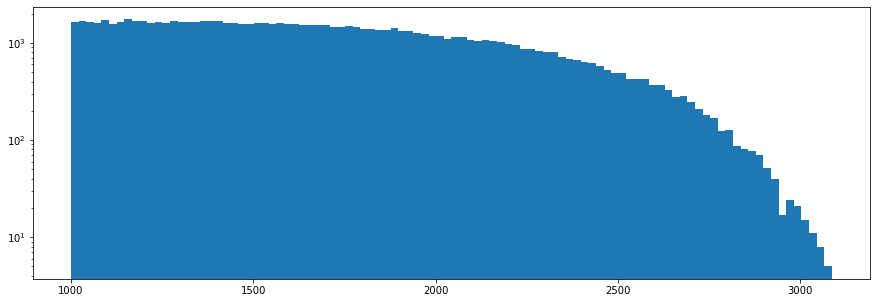

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(samp,bins=100)
plt.yscale("log")
plt.show()

In [13]:
initialScaleFactor = 1
finalScaleFactor = 1.1

samp1 = []
samp2 = []
for i in range(100000):
    samp1.append(ref_spectrum.GetRandom()*initialScaleFactor)
    samp2.append(ref_spectrum.GetRandom()*finalScaleFactor)

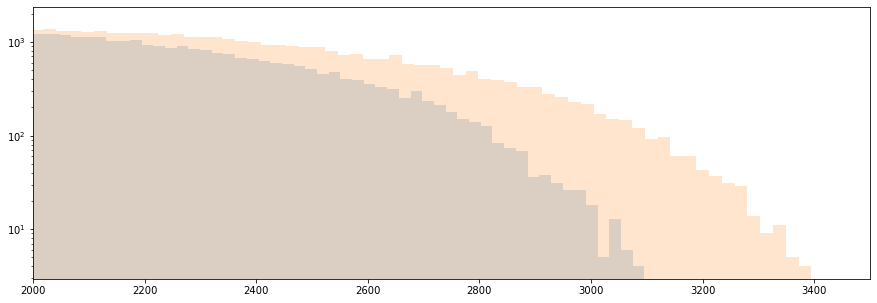

In [14]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(samp1,bins=100,alpha=0.2)
plt.hist(samp2,bins=100,alpha=0.2)
plt.yscale("log")
plt.xlim(2000,3500)
plt.show()

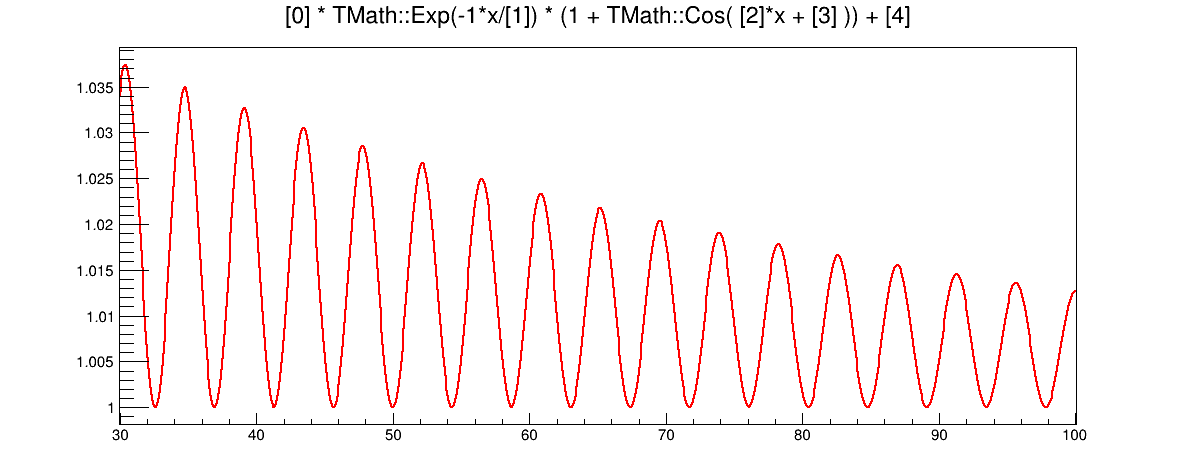

In [15]:
fgain = r.TF1("fgain", "[0] * TMath::Exp(-1*x/[1]) * (1 + TMath::Cos( [2]*x + [3] )) + [4]",0,700,5)
fgain.SetParameters(0.03, 64.4, 0.23*math.pi*2, 0, 1)
fgain.SetNpx(10000)
c = r.TCanvas("c","C",1200,500)
fgain.Draw()
fgain.GetXaxis().SetRangeUser(30,100)
c.Draw()

In [16]:
npoints = 5000
nsamples = 5000000

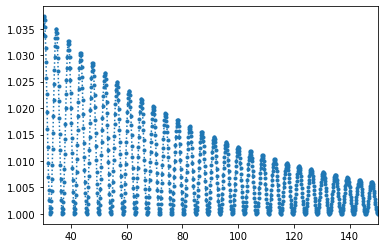

In [17]:
# factors = np.linspace(initialScaleFactor, finalScaleFactor,npoints)
factors = []
times = []
for i in np.linspace(30,650,npoints):
    factors.append(fgain.Eval(i))
    times.append(i)

plt.plot(times,factors,".:")
plt.xlim(30,150)
plt.show()

In [ ]:
%%time

hists = []

h_ref = r.TH1I("h_ref", "Reference Hist", 100,2000,3100)

for j, scalefactor in enumerate(factors):
    if(j % 100 == 0):
        print(j, scalefactor)
    hi = h_ref.Clone("h_"+str(scalefactor))
    hi.Reset()
    sampi = []
    for i in range(nsamples):
        hi.Fill(ref_spectrum.GetRandom()*scalefactor)
    hists.append((scalefactor, hi.Clone("h_"+str(scalefactor))))
# print(hists)

0 1.034060640260024
100 1.0157808165002253
200 1.002694974469956
300 1.0003707755242992
400 1.0054922898779064
500 1.0109303565740426
600 1.011830096444579
700 1.0081928129212805
800 1.0032918888536844
900 1.0003451299571284
1000 1.000293609539855
1100 1.0018634955708503
1200 1.0031378106092461
1300 1.0030715561074794
1400 1.0019235401867512
1500 1.0006531944152488
1600 1.000028693488059
1700 1.0001531631285998
1800 1.0006016950090029
1900 1.0008793076248668


In [ ]:
ks = []

h_ref = hists[len(hists)-1][1]

for scale, hi in hists:
    ksi = h_ref.Chi2Test(hi,"UU NORM CHI2/NDF")
    ks.append(ksi)

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(times, ks)
plt.show()

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(15,8))
for i,axi in enumerate(ax):
    axi.plot(times,ks)
    axi.set_xlim(30+(100*i),100+(100*i))
    axi.grid()
plt.yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
pol0 = r.TF1("pol0","pol0",0,1000)
fit = fitVector(times,ks,pol0)
fit.draw()
plt.show()

In [ ]:
fit.fft([30,600])
plt.show()

In [ ]:
df = pandas.DataFrame([x for x in zip(times,ks)],columns=['time', 'chisquare'])
df.to_csv("./data/monte_carlo_chiSquare_"+str(npoints)+"_points_"+str(nsamples)+"_samples.csv", sep="|")